<b> We experiment with choosing different layers for extracting the style and content and compare the results </b>

In [0]:
%matplotlib inline
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<b>Directing to the directory containing dataset

In [0]:
dataset_root_dir= "/content/drive/My Drive/Paint.io"

In [0]:
%pylab inline
import time
import os 
image_dir = dataset_root_dir + '/Images/'
model_dir = dataset_root_dir + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

Populating the interactive namespace from numpy and matplotlib


<b>To conveniently extract outputs of the different layer of the VGG net, we define the VGG structure and upload the weights. </b> \

We also name the layers, <b>'r12'</b> etc, signifying the output of a certain relu layer present after the convolution layer.

We do this mainly for easy facilitation of experiments of trying different layers for style and content extraction.

In [0]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [0]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [0]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Loading weights to the above self defined VGG architecture

In [0]:
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

Now, we take two images, one for extracting the style and another for content. We use paintings of Vangogh for learning the style in this illustration.

In [0]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'Tuebingen_Neckarfront.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(content_image.data.clone(), requires_grad=True)

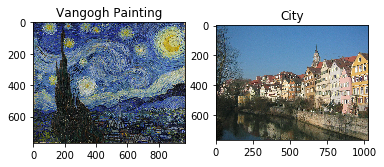

In [0]:
#display images
i=1
for img in imgs:
    plt.subplot(1,2,i)
    plt.imshow(img)

    if i==1:
      plt.title('Vangogh Painting')

    else:
      plt.title('City')
    i=i+1

Now, we do experimentation by choosing different layers for Style and Content.\
Firstly we choose <b>'r11' and 'r21'</b> for style and <b>'r42'</b> for content.

In [0]:
style_layers = ['r11','r21'] 

content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets


#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)

Iteration: 50, loss: 47895.390625
Iteration: 100, loss: 26931.855469
Iteration: 150, loss: 21899.574219
Iteration: 200, loss: 19339.919922
Iteration: 250, loss: 17849.941406
Iteration: 300, loss: 16861.363281
Iteration: 350, loss: 16180.606445
Iteration: 400, loss: 15707.392578
Iteration: 450, loss: 15374.560547
Iteration: 500, loss: 15122.397461


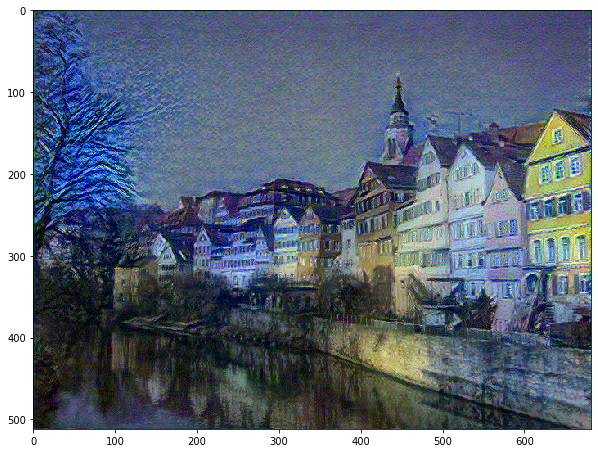

In [0]:
#display result
out_img1 = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img1)
gcf().set_size_inches(10,10)

As the paper claims, the initial layers have the information of <b>Style</b> and deeper in the network architecture, the hidden layers contains the information regarding the <b>content</b>. By choosing 2 layers for style and 1 for content, we see that the style of famous painter Vangogh has been transfered to the picture of the city.

<b>Lets increase the number of layers used for extracting style and content.</b>
Now we choose <b>r11, r21 and r31</b> and <b>r42 and r32</b> for extracting style and content respectively.

In [0]:
style_layers = ['r11','r21','r31'] 

content_layers = ['r42','r32']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256]]
content_weights = [1e0,1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets


#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)

Iteration: 50, loss: 113993.039062
Iteration: 100, loss: 103771.265625
Iteration: 150, loss: 100344.296875
Iteration: 200, loss: 98629.390625
Iteration: 250, loss: 97584.531250
Iteration: 300, loss: 96892.539062
Iteration: 350, loss: 96421.117188
Iteration: 400, loss: 96071.148438
Iteration: 450, loss: 95808.109375
Iteration: 500, loss: 95590.906250


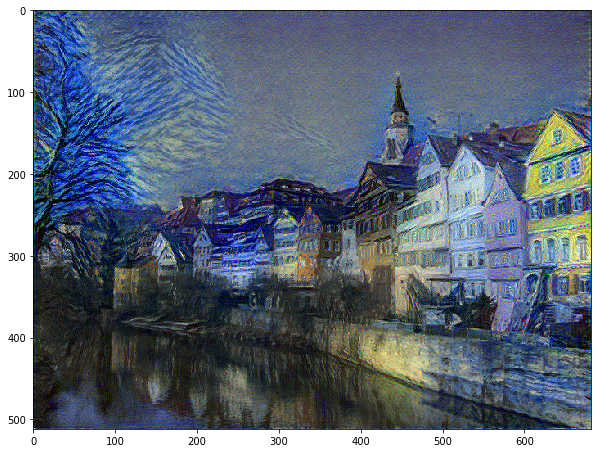

In [0]:
#display result
out_img2 = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img2)
gcf().set_size_inches(10,10)

Let's now use 5 layers <b>r11, r21, r31, r41 and r51</b> for extracting the style and <b>r42, r32 and r22</b> for extracting the content.

In [0]:
style_layers = ['r11','r21','r31','r41','r51'] 

content_layers = ['r42','r32','r22']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0,1e0,1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets


#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)

out_img3 = postp(opt_img.data[0].cpu().squeeze())


Iteration: 50, loss: 600580.375000
Iteration: 100, loss: 470570.375000
Iteration: 150, loss: 431875.250000
Iteration: 200, loss: 414012.750000
Iteration: 250, loss: 402421.968750
Iteration: 300, loss: 394635.687500
Iteration: 350, loss: 388897.437500
Iteration: 400, loss: 384595.562500
Iteration: 450, loss: 381433.937500
Iteration: 500, loss: 378811.187500


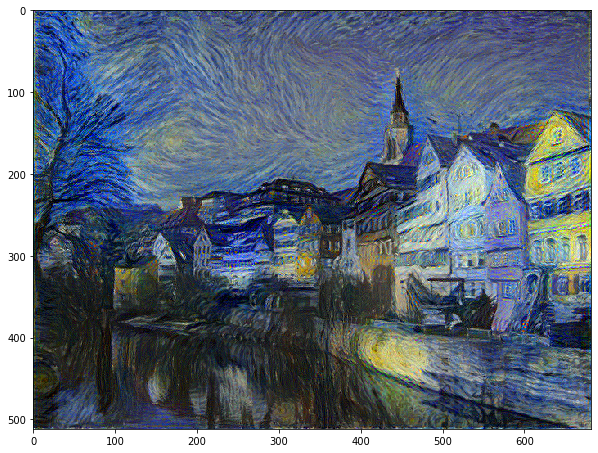

In [0]:
imshow(out_img3)
gcf().set_size_inches(10,10)

<b>Lets compare the 3 results we obtained </b>

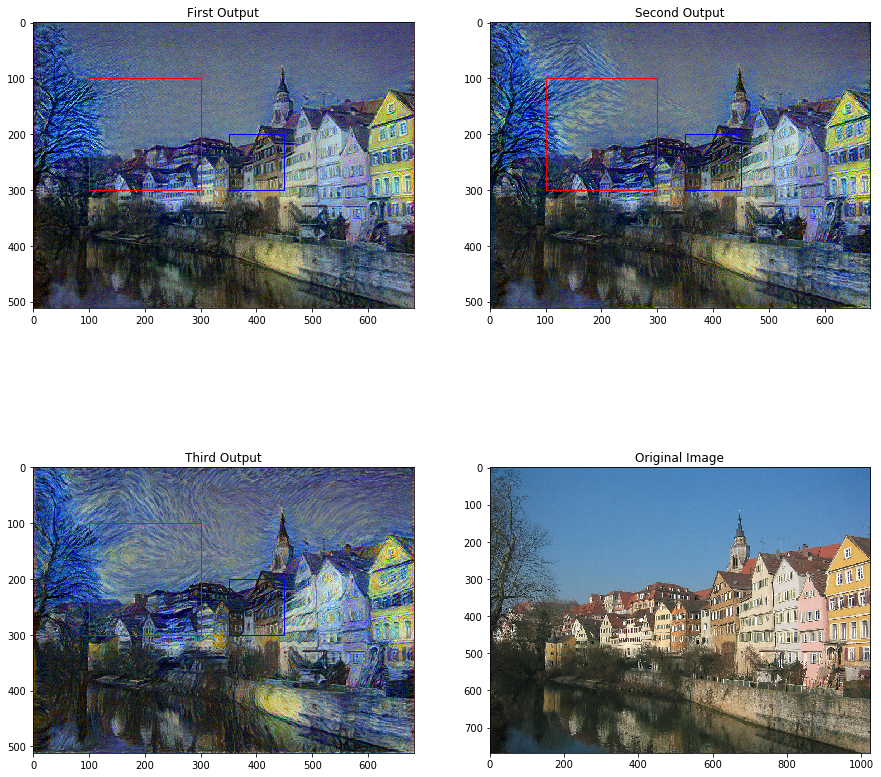

In [0]:
fig, ax = plt.subplots(2,2,figsize=(15,15))
ax[0,0].imshow(out_img1)
ax[0,0].title.set_text('First Output')
rect = patches.Rectangle((100,100),200,200,linewidth=1,edgecolor='r',facecolor='none')
ax[0,0].add_patch(rect)
ax[0,0].add_patch(patches.Rectangle((350,200),100,100,linewidth=1,edgecolor='b',facecolor='none'))


ax[0,1].imshow(out_img2)
ax[0,1].title.set_text('Second Output')
rect = patches.Rectangle((100,100),200,200,linewidth=1,edgecolor='r',facecolor='none')
ax[0,1].add_patch(rect)
ax[0,1].add_patch(patches.Rectangle((350,200),100,100,linewidth=1,edgecolor='b',facecolor='none'))


ax[1,0].imshow(out_img3)
ax[1,0].title.set_text('Third Output')
rect = patches.Rectangle((100,100),200,200,linewidth=1,edgecolor='r',facecolor='none')
ax[1,0].add_patch(rect)
ax[1,0].add_patch(patches.Rectangle((350,200),100,100,linewidth=1,edgecolor='b',facecolor='none'))


ax[1,1].imshow(imgs[1])
ax[1,1].title.set_text('Original Image')


<b>Comparison</b> \
<b>Style</b>: We can see that in terms of style Third > Second > First. This attributes to the fact that we used more number of layers for learning the style of the vangogh paining. This can seen in the red bouding box in the images. \
<b>Content</b> We observe that when we extracted content from the "deep" layers, the building edges were more prominent and similar to the original picture. As in the second and third image, we use layers from middle as well as deeper end of the network with equal weightage i.e. 1e0, the content is getting lost. This can be seen in the edges of the buildings. \

In the third images, building's edges are getting curvy and loosing the property it had in original image. [Blue box]


<b> Lets try something different</b> \
This time we reverse the layers for extracting style and content, that is, use deep layers for style and near layers for content. We know, the results won't be good, but it is still worth a pursue.

content_layers = ['r11','r21']  \

style_layers = ['r42']

In [0]:
content_layers = ['r11','r21'] 

style_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
content_weights = [1e3/n**2 for n in [64,128]]
style_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets


#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)

out_img4 = postp(opt_img.data[0].cpu().squeeze())


Iteration: 50, loss: 11079713.000000
Iteration: 100, loss: 6238476.000000
Iteration: 150, loss: 4451212.500000
Iteration: 200, loss: 3550066.500000
Iteration: 250, loss: 3007225.000000
Iteration: 300, loss: 2640857.500000
Iteration: 350, loss: 2381390.250000
Iteration: 400, loss: 2186032.750000
Iteration: 450, loss: 2027923.750000
Iteration: 500, loss: 1898428.000000


Text(0.5, 1.0, 'Reverse Experiment')

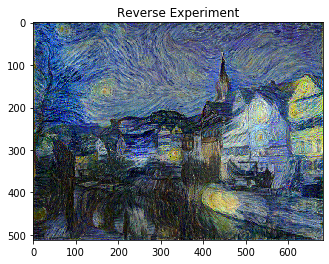

In [0]:
plt.imshow(out_img4)
plt.title('Reverse Experiment')

We can see that, both style and content have started getting lost. This was expected. We tried extracting content from the near layers, and hence couldn't learn the exact style. Similarly, trying to learn style from deep layers led to learning <b>over patterning</b> causing prominent curving in the output.

<b>Experiments with Loss weights </b>\
We know that the overall loss is weighted sum of the style and content loss:
\begin{equation}\mathcal{L} _{total} \left( \vec{p}, \vec{a}, \vec{x}  \right) = \alpha \cdot \mathcal{L} _{content} \left( \vec{p}, \vec{x} \right) + \beta \cdot \mathcal{L} _{style} \left( \vec{a}, \vec{x} \right)
\end{equation}

In all the previous experiments, we used the number of layers used for extracting style and content as the values of $\alpha$ and $\beta$.\

Now, we manually vary $\alpha$ and $\beta$ to demonstrate its effect on the overall result. We consider extreme cases, where we give most weight to content loss in one case and vice versa in the other.

In [0]:
style_layers = ['r11','r21'] 

content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e5/n**2 for n in [64,128]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets


#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)

out151 = postp(opt_img.data[0].cpu().squeeze())


Iteration: 50, loss: 233586.218750
Iteration: 100, loss: 128767.242188
Iteration: 150, loss: 92992.148438
Iteration: 200, loss: 75373.835938
Iteration: 250, loss: 64293.097656
Iteration: 300, loss: 57265.160156
Iteration: 350, loss: 51962.109375
Iteration: 400, loss: 48052.101562
Iteration: 450, loss: 45194.175781
Iteration: 500, loss: 42975.843750


In [0]:
style_layers = ['r11','r21'] 

content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128]]
content_weights = [1e2]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets


#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)

out130 = postp(opt_img.data[0].cpu().squeeze())


Iteration: 50, loss: 1490255.625000
Iteration: 100, loss: 914888.000000
Iteration: 150, loss: 681512.750000
Iteration: 200, loss: 570558.312500
Iteration: 250, loss: 508331.718750
Iteration: 300, loss: 465652.031250
Iteration: 350, loss: 436884.593750
Iteration: 400, loss: 415247.093750
Iteration: 450, loss: 398513.312500
Iteration: 500, loss: 385084.875000


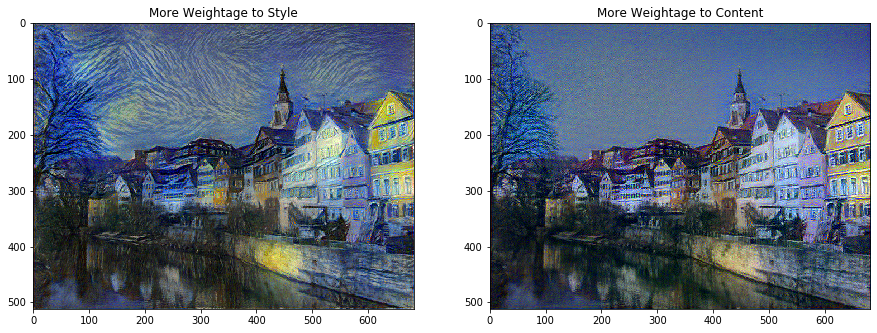

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
fig = plt.figure(1)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(out151)
ax1.title.set_text('More Weightage to Style')
ax2.imshow(out130)
ax2.title.set_text('More Weightage to Content')


We see that using <b>'r11' and 'r21'</b> and <b>'r42'</b> for extracting style and content, we change the weights given to these two components governing the overall loss function.

In the extreme case when large weight is given to style, we can clearly see the style dominates. Whereas when we give large weight to the content, content dominates.